# Data preprocessing code

The original code has been kindly provided by Tavpritesh Sethi and his team at the Indraprastha Institute of Information Technology, Delhi. 

- Original notebook and data source is https://github.com/tavlab-iiitd/ESCMIDWorkshop2025/tree/main
- Repository for the TavLab https://github.com/tavlab-iiitd 
- Website for the TavLab https://tavlab.iiitd.edu.in/

It has been modified by @benjaminmcf to ensure that it works with Google colab, in addition to adding some more comments.

Data required for this notebook includes the following:
- breakpoint.csv
- data_long.csv
- data_wide.csv

## What skills are covered in the notebook
- Loading interpreting data with python
- Examples of processing data in wide and long formats

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
"""
AMST data are generally available in two formats: antibiotics in rows (long format) and 
antibiotics in columns (wide format)
Loading both the datasets
"""
# load in the long format data
long_df = pd.read_csv('../DATA/data_long.csv')
# load in the wide format data
wide_df = pd.read_csv('../DATA/data_wide.csv')

In [ ]:
#Defining and using a function to have a brief look the data
def peek(df, name):
    print(f"--- {name} sample ({df.shape[0]} rows, {df.shape[1]} cols) ---")
    print(df.head())

peek(long_df, 'Long format')

In [ ]:
""" 
We can have a look at the names of the columns in the long format data.
We can see if there are any missing values in the data.
And we can see the data types of the columns.
"""
long_df.info()

In [ ]:
# Having a quick look at the wide format data
peek(wide_df, 'Wide format')

In [ ]:
""" 
We can have a look at the names of the columns in the wide format data.
We can see if there are any missing values in the data.
And we can see the data types of the columns.
"""
wide_df.info()

## Example of cleaning and processing "long" data

In [ ]:
"""  
Lets check the antibiotic values in the dataset. 
The dataset may contain pre-categorised antibiotic values as Resistant, 
Susceptible or Intermediate. If you have the raw Disk Diffusion (DD) or MIC values, 
you can convert to R/I/S based on CLSI or EUCAST guidelines.

The code below shows how you might classify each row of the long data as Susceptible,
Resistant, or Intermediate based on the Disk Diffusion (DD) values and the corresponding breakpoints.
"""

#Upload guidelines from csv file
guidelines = pd.read_csv('../DATA/breakpoint.csv')

#An easy method is to merge breakpoints to the original data and compare. Without merging comparison is also possible.
merged_df = long_df.merge(guidelines, on=['organism', 'antibiotic'], how='left')

print (merged_df)

# Function to classify AST result based on disk diffusion (DD) values
def classify(row):
    """
    Return:
      - 'Susceptible' if DD_Values ≥ s_dd
      - 'Resistant'   if DD_Values ≤ r_dd
      - 'Intermediate' otherwise
    """
    dd = row['DD_Values']
    s  = row['s_dd']
    r  = row['r_dd']

    # If any of the key values are missing, we can’t classify
    if pd.isnull(dd) or pd.isnull(s) or pd.isnull(r):
        return np.nan

    # Order matters: check Susceptible first, then Resistant, then Intermediate
    if dd >= s:
        return 'Susceptible'
    elif dd <= r:
        return 'Resistant'
    else:
        return 'Intermediate'

# Apply the classify function to each row in the merged DataFrame
merged_df['category'] = merged_df.apply(classify, axis=1)

In [14]:
# Looking at our newly created dataframe
merged_df.head()

,ID,date of sample collection,type of sample,date of admission,department,location in hospital,gender,dob,location,DD_Values,antibiotic,organism,s_dd,i_dd,r_dd,category
0,A1,01/01/17,Blood,31/12/16,Hepatology,Ward,male,31/12/48,A,25,Amikacin,Escherichia coli,17.0,NaN,16.0,Susceptible
1,A1,01/01/17,Blood,31/12/16,Hepatology,Ward,male,31/12/48,A,27,Cefoperazone-sulbactam,Escherichia coli,NaN,NaN,NaN,NaN
2,A1,01/01/17,Blood,31/12/16,Hepatology,Ward,male,31/12/48,A,22,Ciprofloxacin,Escherichia coli,25.0,24.0,21.0,Intermediate
3,A2,01/01/17,Blood,31/12/16,Hepatology,Ward,female,31/12/48,A,11,Doxycycline,Escherichia coli,19.0,18.0,15.0,Resistant
4,A2,01/01/17,Blood,31/12/16,Hepatology,Ward,female,31/12/48,A,10,Ertapenem,Escherichia coli,27.0,26.0,23.0,Resistant


In [15]:
# View the number of samples with each susceptibility category
merged_df['category'].value_counts()

category
Susceptible     8
Resistant       7
Intermediate    2
Name: count, dtype: int64

In [ ]:
# Converting to antibiotics as columns
wide_from_long = merged_df.pivot_table(
    index=['ID', 'organism'],
    columns='antibiotic',
    values='category',
    aggfunc='first'
).reset_index()

print(wide_from_long.head())

## Example of cleaning, preprocessing, and visualising the "wide" dataset



In [16]:
#Cleaning & preprocessing the wide dataset
# Creating a copy of the wide dataframe, naming it data
data = wide_df.copy()

In [17]:
data.head()

,Study,Species,Family,Country,State,Gender,Age.Group,Speciality,Source,In...Out.Patient,...,Ciprofloxacin_I,Colistin_I,Daptomycin_I,Doripenem_I,Ertapenem_I,Sulbactam,Teicoplanin_I,Tetracycline_I,Cefpodoxime_I,Ceftibuten_I
0,C,Staphylococcus aureus,Staphylococcus spp,Z1,NaN,Female,19 to 64 Years,Medicine ICU,Sputum,NaN,...,Susceptible,Intermediate,Susceptible,NaN,NaN,NaN,Susceptible,NaN,NaN,NaN
1,A,Haemophilus influenzae,Haemophilus spp,Z7,Y3,Female,85 and Over,Emergency Room,Sputum,Inpatient,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,Klebsiella oxytoca,Enterobacteriaceae,Z3,NaN,Male,19 to 64 Years,Surgery General,Sputum,Inpatient,...,NaN,NaN,NaN,NaN,Susceptible,NaN,NaN,NaN,NaN,NaN
3,C,Escherichia coli,Enterobacterales,Z24,NaN,Male,65 to 84 Years,Emergency Room,Urine,NaN,...,NaN,Intermediate,Susceptible,NaN,NaN,NaN,NaN,NaN,NaN,Susceptible
4,C,Acinetobacter baumannii,Non-Enterobacteriaceae,Z11,NaN,Male,65 to 84 Years,Medicine General,Urine,None Given,...,Resistant,Intermediate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
len(data)

9984

In [19]:
# View column names before cleaning
data.columns

Index(['Study', 'Species', 'Family', 'Country', 'State', 'Gender', 'Age.Group',
       'Speciality', 'Source', 'In...Out.Patient', 'Year', 'Phenotype',
       'Amikacin_I', 'Amoxycillin.clavulanate_I', 'Ampicillin_I',
       'Azithromycin_I', 'Cefepime_I', 'Cefoxitin_I', 'Ceftazidime_I',
       'Ceftriaxone_I', 'Clarithromycin_I', 'Clindamycin_I', 'Erythromycin_I',
       'Imipenem_I', 'Levofloxacin_I', 'Linezolid_I', 'Meropenem_I',
       'Metronidazole', 'Metronidazole_I', 'Minocycline_I', 'Penicillin_I',
       'Piperacillin.tazobactam_I', 'Tigecycline_I', 'Vancomycin_I',
       'Ampicillin.sulbactam_I', 'Aztreonam_I', 'Cefixime_I', 'Ceftaroline_I',
       'Ceftazidime.avibactam_I', 'Ciprofloxacin_I', 'Colistin_I',
       'Daptomycin_I', 'Doripenem_I', 'Ertapenem_I', 'Sulbactam',
       'Teicoplanin_I', 'Tetracycline_I', 'Cefpodoxime_I', 'Ceftibuten_I'],
      dtype='object')

In [20]:
#Clean column names
data.columns = (
    data.columns
      .str.strip()
      .str.lower()
      .str.replace('[^0-9a-z]+', '_', regex=True)
)

In [21]:
# view column names after cleaning
data.columns

Index(['study', 'species', 'family', 'country', 'state', 'gender', 'age_group',
       'speciality', 'source', 'in_out_patient', 'year', 'phenotype',
       'amikacin_i', 'amoxycillin_clavulanate_i', 'ampicillin_i',
       'azithromycin_i', 'cefepime_i', 'cefoxitin_i', 'ceftazidime_i',
       'ceftriaxone_i', 'clarithromycin_i', 'clindamycin_i', 'erythromycin_i',
       'imipenem_i', 'levofloxacin_i', 'linezolid_i', 'meropenem_i',
       'metronidazole', 'metronidazole_i', 'minocycline_i', 'penicillin_i',
       'piperacillin_tazobactam_i', 'tigecycline_i', 'vancomycin_i',
       'ampicillin_sulbactam_i', 'aztreonam_i', 'cefixime_i', 'ceftaroline_i',
       'ceftazidime_avibactam_i', 'ciprofloxacin_i', 'colistin_i',
       'daptomycin_i', 'doripenem_i', 'ertapenem_i', 'sulbactam',
       'teicoplanin_i', 'tetracycline_i', 'cefpodoxime_i', 'ceftibuten_i'],
      dtype='object')

In [22]:
# Looking at the difference
# In Python, :<30 is used in string formatting and means:
#"Left-align the value in a field that is 30 characters wide."
for col_name in zip(wide_df.columns, data.columns):
    print(f"{col_name[0]:<30} -> {col_name[1]}")

Study                          -> study
Species                        -> species
Family                         -> family
Country                        -> country
State                          -> state
Gender                         -> gender
Age.Group                      -> age_group
Speciality                     -> speciality
Source                         -> source
In...Out.Patient               -> in_out_patient
Year                           -> year
Phenotype                      -> phenotype
Amikacin_I                     -> amikacin_i
Amoxycillin.clavulanate_I      -> amoxycillin_clavulanate_i
Ampicillin_I                   -> ampicillin_i
Azithromycin_I                 -> azithromycin_i
Cefepime_I                     -> cefepime_i
Cefoxitin_I                    -> cefoxitin_i
Ceftazidime_I                  -> ceftazidime_i
Ceftriaxone_I                  -> ceftriaxone_i
Clarithromycin_I               -> clarithromycin_i
Clindamycin_I                  -> clindamycin_i
Eryth

In [23]:
#Identify missingness
for col in data.columns:
    cnt = data[col].isnull().sum()
    pct = data[col].isnull().mean() * 100
    print(f"{col}: {cnt} missing ({pct:.2f}%)")

study: 0 missing (0.00%)
species: 0 missing (0.00%)
family: 0 missing (0.00%)
country: 0 missing (0.00%)
state: 8277 missing (82.90%)
gender: 349 missing (3.50%)
age_group: 0 missing (0.00%)
speciality: 0 missing (0.00%)
source: 0 missing (0.00%)
in_out_patient: 2495 missing (24.99%)
year: 0 missing (0.00%)
phenotype: 7308 missing (73.20%)
amikacin_i: 4199 missing (42.06%)
amoxycillin_clavulanate_i: 5155 missing (51.63%)
ampicillin_i: 4836 missing (48.44%)
azithromycin_i: 9664 missing (96.79%)
cefepime_i: 3895 missing (39.01%)
cefoxitin_i: 9906 missing (99.22%)
ceftazidime_i: 4849 missing (48.57%)
ceftriaxone_i: 6059 missing (60.69%)
clarithromycin_i: 9752 missing (97.68%)
clindamycin_i: 7633 missing (76.45%)
erythromycin_i: 7587 missing (75.99%)
imipenem_i: 6343 missing (63.53%)
levofloxacin_i: 241 missing (2.41%)
linezolid_i: 6409 missing (64.19%)
meropenem_i: 3155 missing (31.60%)
metronidazole: 9787 missing (98.03%)
metronidazole_i: 9781 missing (97.97%)
minocycline_i: 5373 missing

In [24]:
# Looking at the unique values in the 'country' column
data["country"].unique()

array(['Z1', 'Z7', 'Z3', 'Z24', 'Z11', 'Z27', 'Z23', 'Z41', 'Z2', 'Z5',
       'Z10', 'Z25', 'Z17', 'Z38', 'Z8', 'Z47', 'Z13', 'Z20', 'Z51',
       'Z42', 'Z36', 'Z12', 'Z4', 'Z28', 'Z15', 'Z32', 'Z34', 'Z63',
       'Z22', 'Z50', 'Z54', 'Z14', 'Z52', 'Z18', 'Z9', 'Z43', 'Z19', 'Z6',
       'Z39', 'Z35', 'Z55', 'Z33', 'Z44', 'Z21', 'Z40', 'Z29', 'Z48',
       'Z57', 'Z64', 'Z59', 'Z81', 'Z53', 'Z16', 'Z30', 'Z26', 'Z49',
       'Z45', 'Z69', 'Z68', 'Z37', 'Z46', 'Z60', 'Z62', 'Z72', 'Z65',
       'Z67', 'Z78', 'Z58', 'Z31', 'Z61', 'Z82', 'Z83', 'Z76', 'Z73',
       'Z75', 'Z70', 'Z66', 'Z56', 'Z77', 'Z79'], dtype=object)

In [25]:
def plot_value_counts_bar(data, column, top_n=15, sort_index=False, figsize=(10, 6)):
    """
    Plot a bar chart of value counts for a given column.

    Parameters:
    - data   : pandas DataFrame
    - column : str, column name to plot
    - top_n  : int or None; if int, plot the top_n categories; if None, plot all categories
    - figsize: tuple, figure size (width, height)
    """

    if sort_index:
        data[column].sort_index()


    # Compute value counts
    vc = data[column].value_counts()
    if top_n is not None:
        vc = vc.nlargest(top_n)
    vc = vc.sort_values(ascending=False)

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    vc.plot.bar(ax=ax, edgecolor='black', width=0.8)

    # Titles and labels
    title = f"Top {top_n} {column.capitalize()}" if top_n is not None else f"{column.capitalize()} Counts"
    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel(column.capitalize(), fontsize=14, labelpad=10)
    ax.set_ylabel("Number of Records", fontsize=14, labelpad=10)

    # Ticks and grid
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [28]:
def plot_value_counts_bar(data, column, top_n=15, sort_index=False, figsize=(10, 6)):
    """
    Plot a professional bar chart of value counts for a given column.

    Parameters:
    - data       : pandas DataFrame
    - column     : str, column name to plot
    - top_n      : int or None; if int, take the top_n categories by count; if None, consider all
    - sort_index : bool; if True, sort the result by index (x-axis labels) instead of by values
    - figsize    : tuple, figure size (width, height)
    """
    # Compute raw value counts
    vc = data[column].value_counts()

    # If top_n specified, take the top_n largest counts first
    if top_n is not None:
        vc = vc.nlargest(top_n)

    # Sort either by index or by count
    if sort_index:
        vc = vc.sort_index()
        title = f"{column.capitalize()} Counts (sorted by index)"
    else:
        vc = vc.sort_values(ascending=False)
        title = f"Top {top_n} {column.capitalize()}" if top_n is not None else f"{column.capitalize()} Counts"

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    vc.plot.bar(ax=ax, edgecolor='black', width=0.8)

    # Titles and labels
    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel(column.capitalize(), fontsize=14, labelpad=10)
    ax.set_ylabel("Number of Records", fontsize=14, labelpad=10)

    # Ticks and grid
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


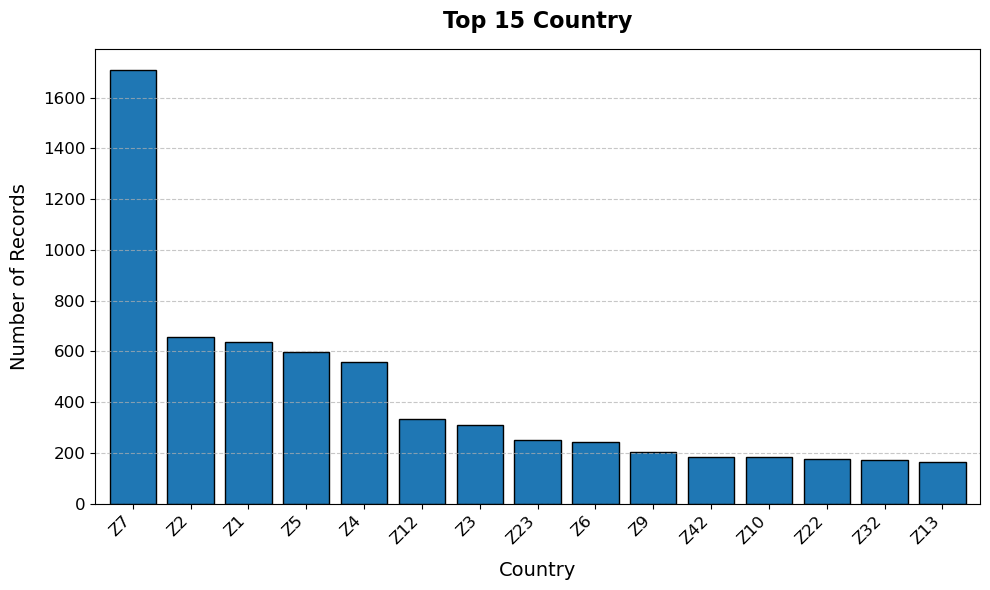

In [29]:
plot_value_counts_bar(data, "country", top_n=15)

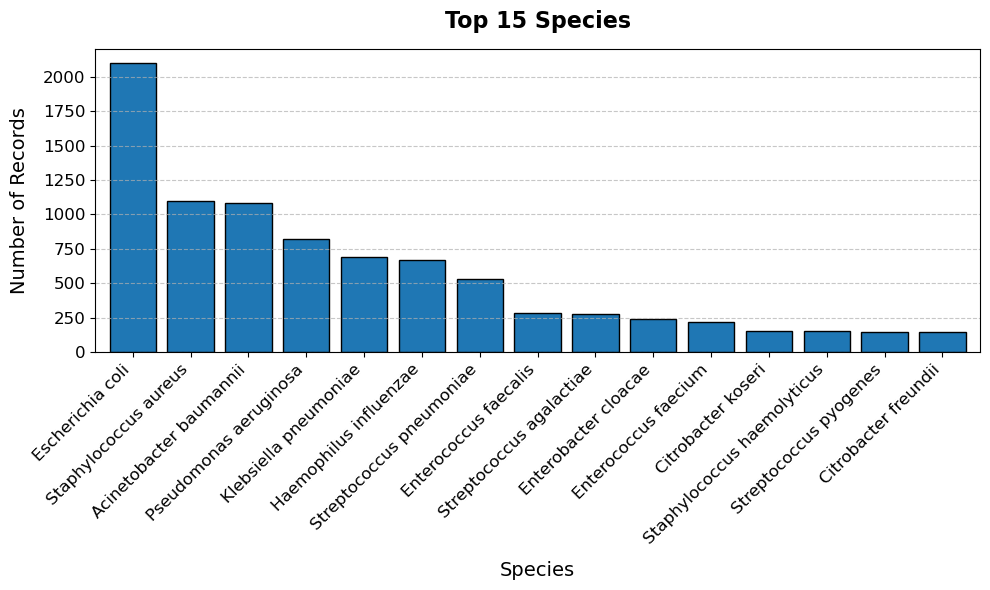

In [30]:
plot_value_counts_bar(data, "species", top_n=15)

In [31]:
data["species"].value_counts().head(20)

species
Escherichia coli               2099
Staphylococcus aureus          1097
Acinetobacter baumannii        1080
Pseudomonas aeruginosa          822
Klebsiella pneumoniae           689
Haemophilus influenzae          668
Streptococcus pneumoniae        531
Enterococcus faecalis           281
Streptococcus agalactiae        279
Enterobacter cloacae            237
Enterococcus faecium            219
Citrobacter koseri              155
Staphylococcus haemolyticus     154
Streptococcus pyogenes          148
Citrobacter freundii            143
Serratia marcescens             122
Staphylococcus epidermidis      116
Klebsiella aerogenes            112
Enterobacter spp                 89
Klebsiella oxytoca               78
Name: count, dtype: int64

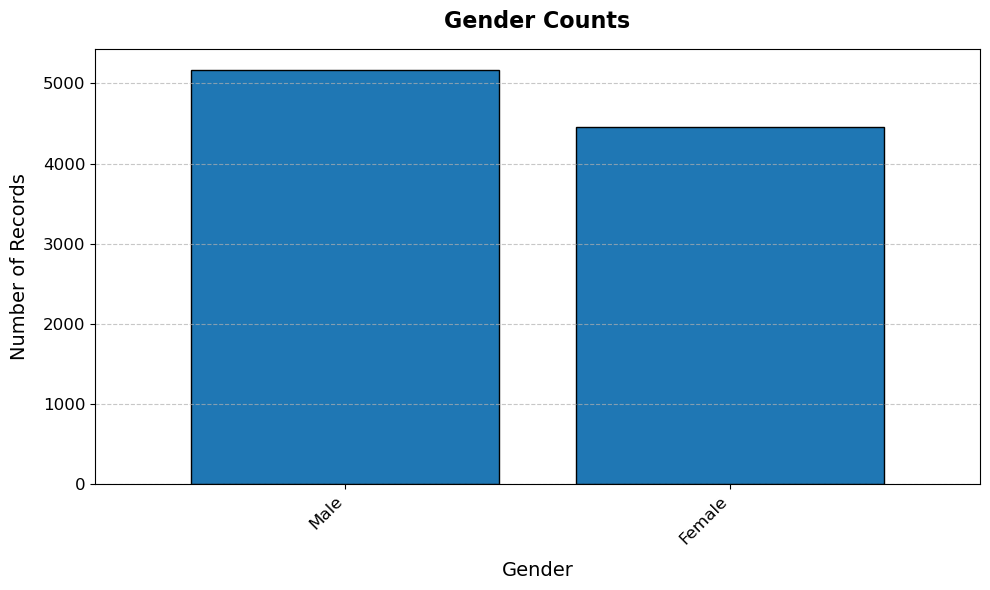

In [32]:
plot_value_counts_bar(data, "gender", top_n=None)

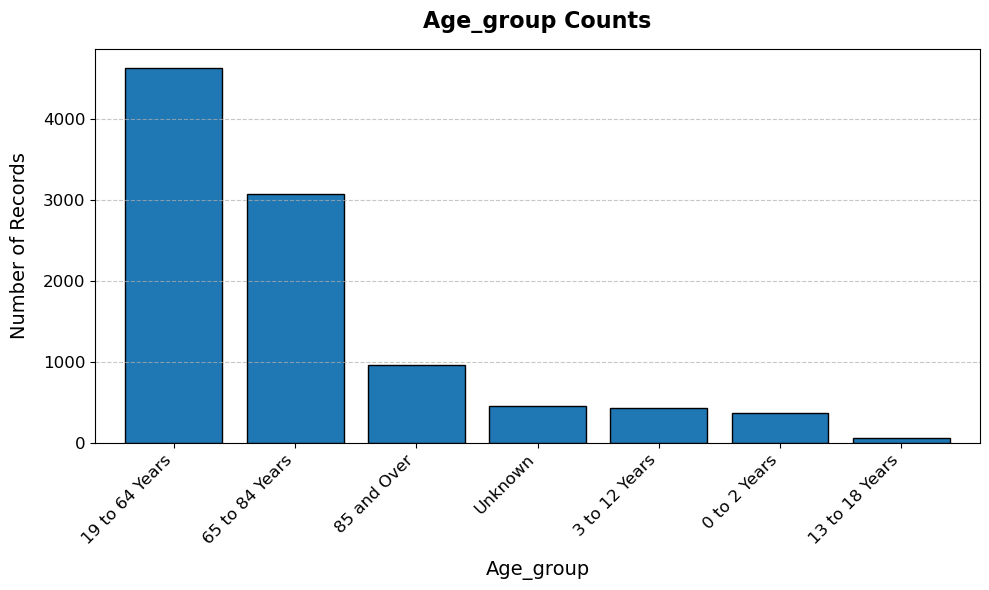

In [33]:
plot_value_counts_bar(data, "age_group", top_n=None)

In [35]:
# Looking at the number of samples each year
data["year"].value_counts().sort_index()

year
2004    218
2005    237
2006    327
2007    434
2008    400
2009    457
2010    350
2011    280
2012    556
2013    765
2014    767
2015    709
2016    758
2017    633
2018    516
2019    627
2020    657
2021    684
2022    609
Name: count, dtype: int64

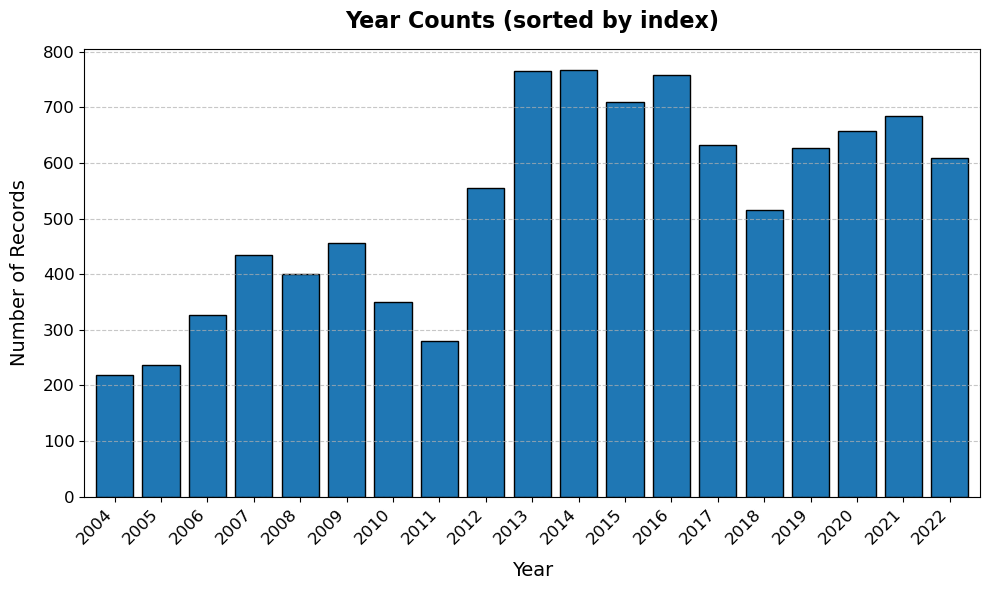

In [36]:
plot_value_counts_bar(data, "year", top_n=None, sort_index=True)

In [39]:
# Looking at the distribution of samples sources
data["source"].value_counts()

source
Blood                    1940
Wound                    1429
Sputum                   1362
Urine                    1280
Endotracheal aspirate     434
                         ... 
CNS: Other                  1
Peripheral Nerves           1
Brain                       1
Head                        1
Lymphatic Fluid             1
Name: count, Length: 82, dtype: int64

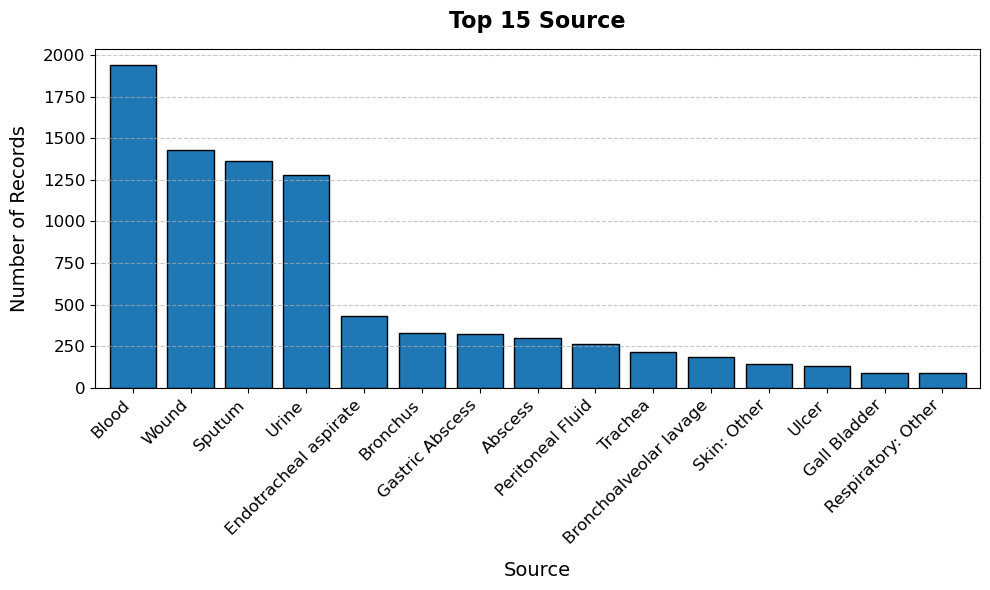

In [40]:
plot_value_counts_bar(data, "source", top_n=15)

In [41]:
# Filtering the data for a specific region
data_region= data[data["country"] == "Z7"]

In [42]:
# Quick look at the filtered data
data_region.head()

,study,species,family,country,state,gender,age_group,speciality,source,in_out_patient,...,ciprofloxacin_i,colistin_i,daptomycin_i,doripenem_i,ertapenem_i,sulbactam,teicoplanin_i,tetracycline_i,cefpodoxime_i,ceftibuten_i
1,A,Haemophilus influenzae,Haemophilus spp,Z7,Y3,Female,85 and Over,Emergency Room,Sputum,Inpatient,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,A,Staphylococcus aureus,Staphylococcus spp,Z7,Y3,Male,19 to 64 Years,Medicine General,Gastric Abscess,Inpatient,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,A,Escherichia coli,Enterobacteriaceae,Z7,Y10,Female,19 to 64 Years,Emergency Room,Trachea,Inpatient,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,A,Haemophilus influenzae,Haemophilus spp,Z7,Y3,Female,85 and Over,Emergency Room,Abdominal Fluid,Outpatient,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,C,Enterobacter spp,Enterobacteriaceae,Z7,Y16,Female,85 and Over,Medicine General,Endotracheal aspirate,None Given,...,Susceptible,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


                   species  year  count
0  Acinetobacter baumannii  2012    107
1  Acinetobacter baumannii  2014    105
2  Acinetobacter baumannii  2021     69
3         Enterobacter spp  2020     72
4     Enterococcus faecium  2005    154 



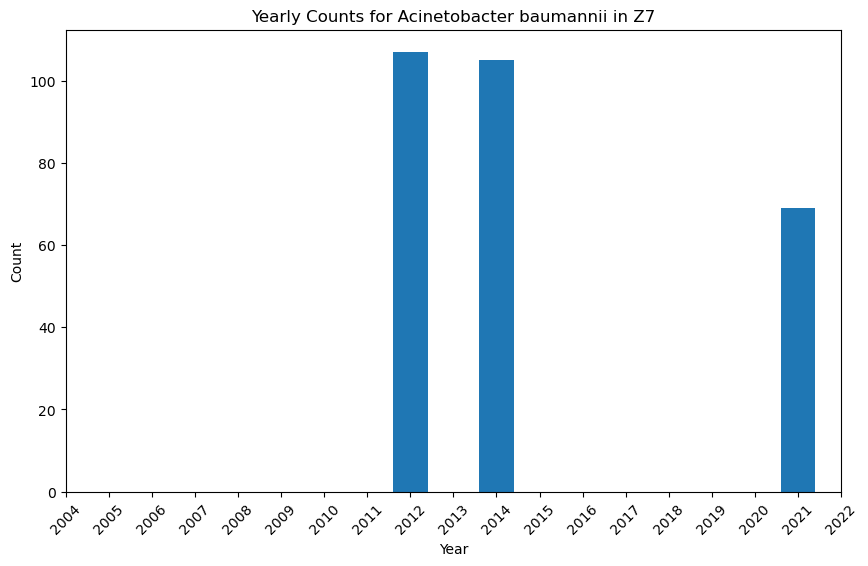

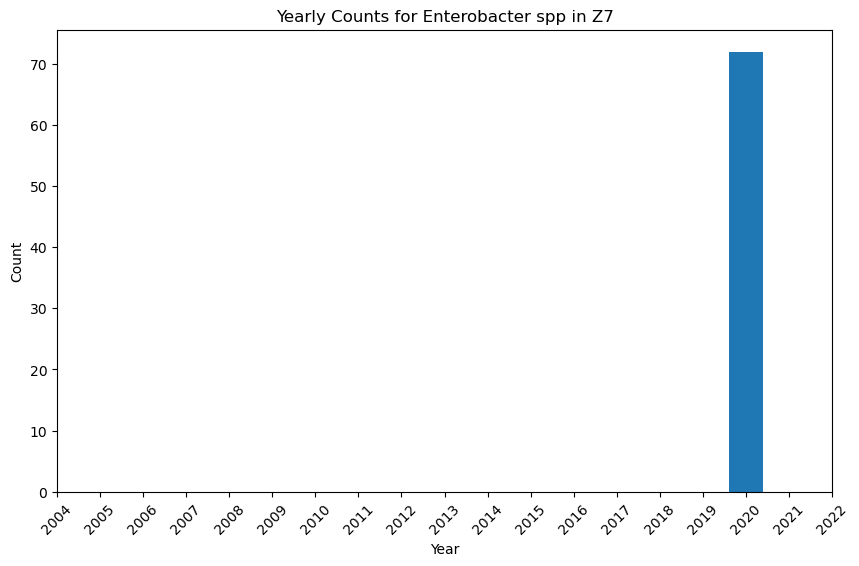

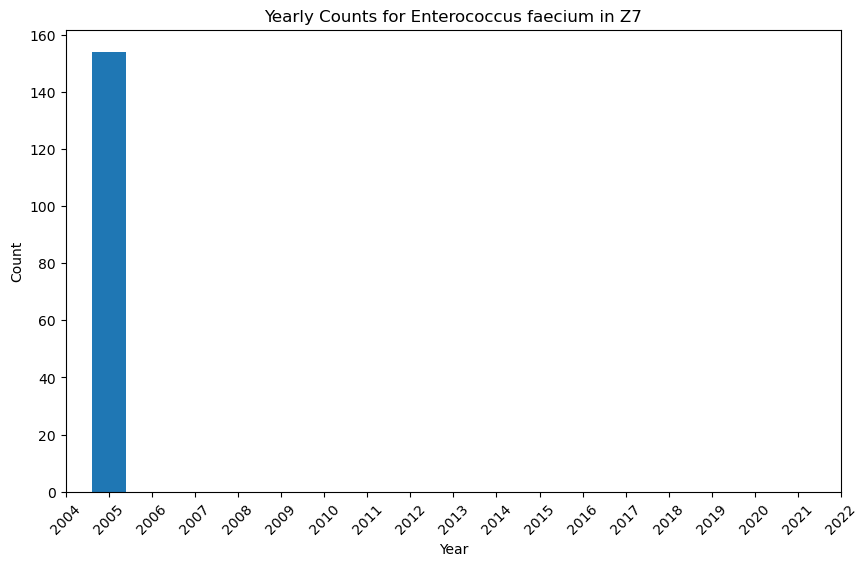

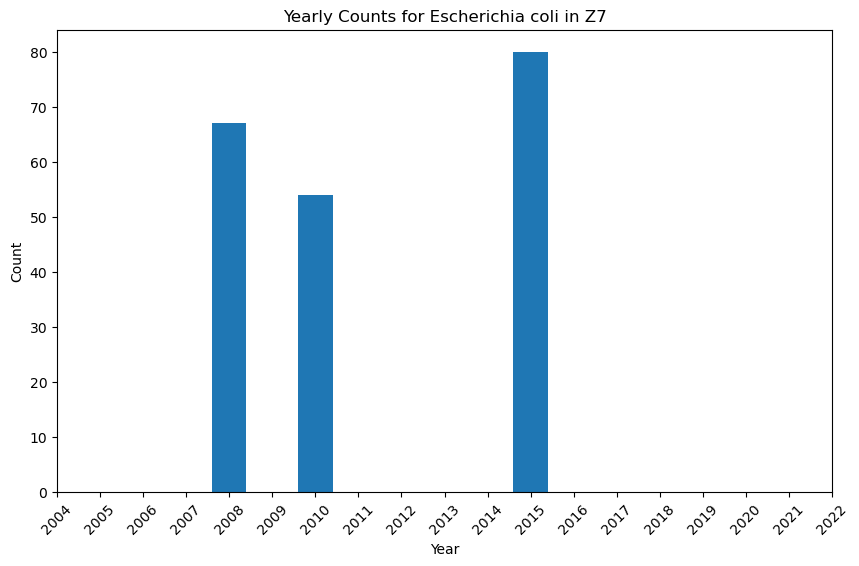

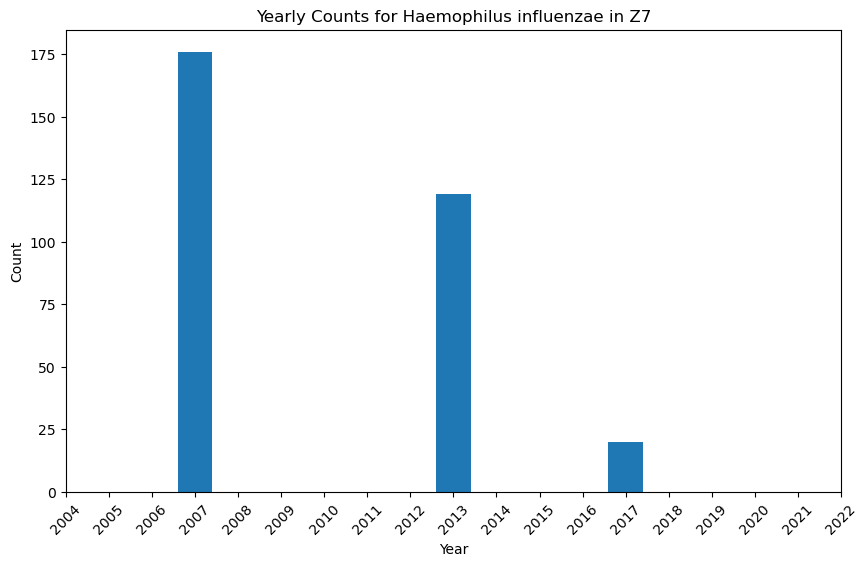

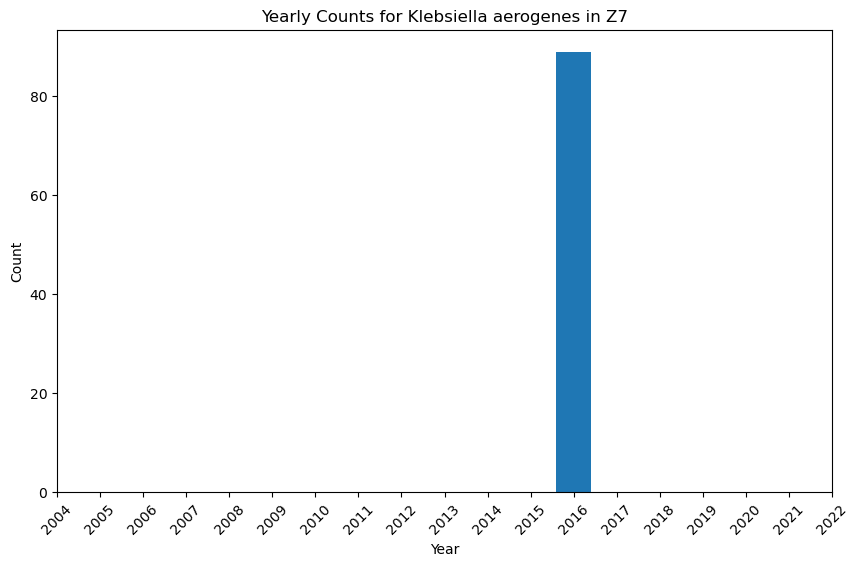

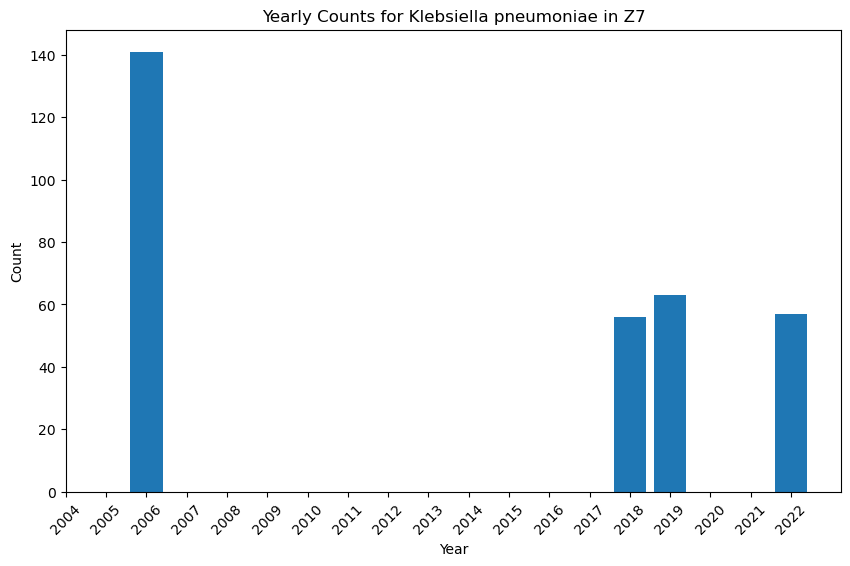

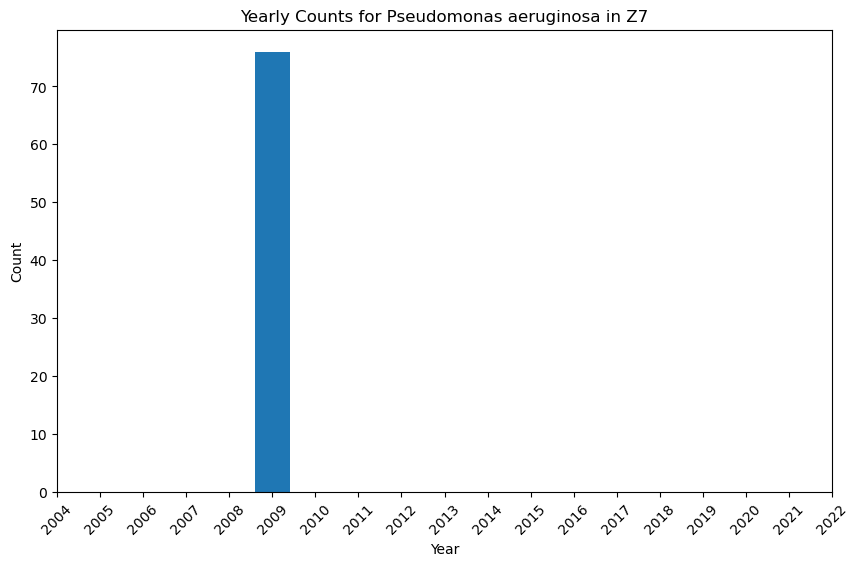

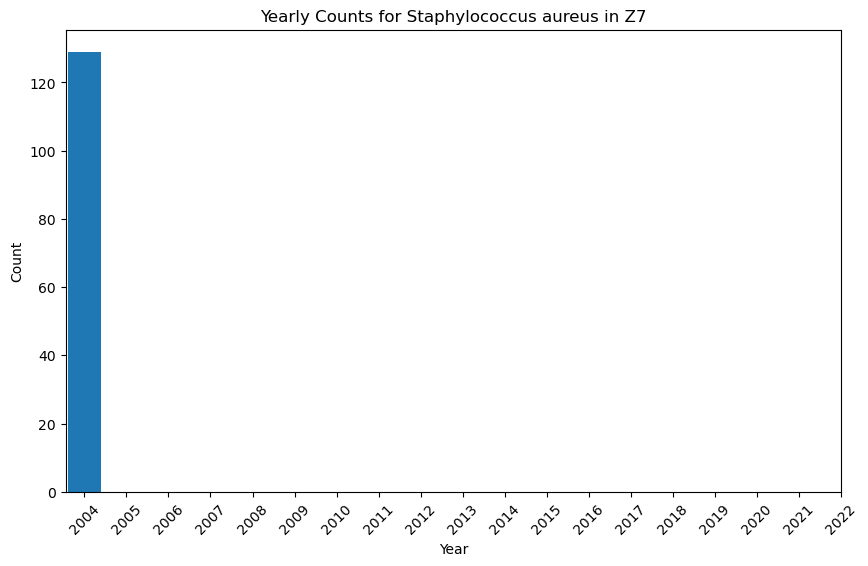

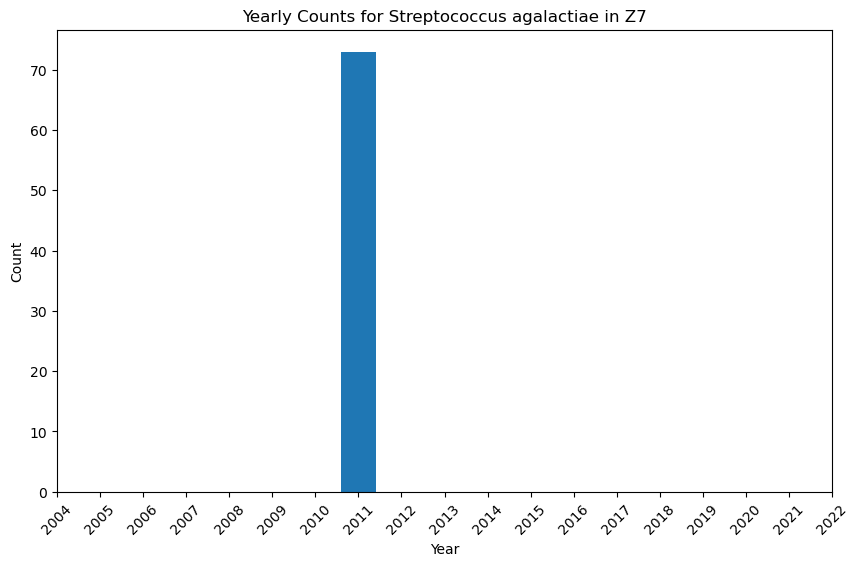

In [ ]:
# Creating a dataframe to plot yearly counts for each species in region Z7
data_region_grouped = (data_region.groupby(['species','year']).size().reset_index(name='count'))

unique_species = data_region_grouped['species'].unique()
all_years      = sorted(data_region_grouped['year'].unique())

# viewing the dataframe. The '\n' is used to add a newline for better readability in the output
print(data_region_grouped.head(),'\n')

for species in unique_species:
    species_data = data_region_grouped[data_region_grouped['species'] == species]

    plt.figure(figsize=(10,6))
    plt.bar(species_data['year'], species_data['count'])
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title(f'Yearly Counts for {species} in Z7')
    plt.xticks(all_years, rotation=45)
    plt.show()


                   species           source  count
0  Acinetobacter baumannii  Abdominal Fluid      5
1  Acinetobacter baumannii          Abscess     45
2  Acinetobacter baumannii         Appendix      2
3  Acinetobacter baumannii         Aspirate      1
4  Acinetobacter baumannii             Bile      1 



<Figure size 1500x1000 with 0 Axes>

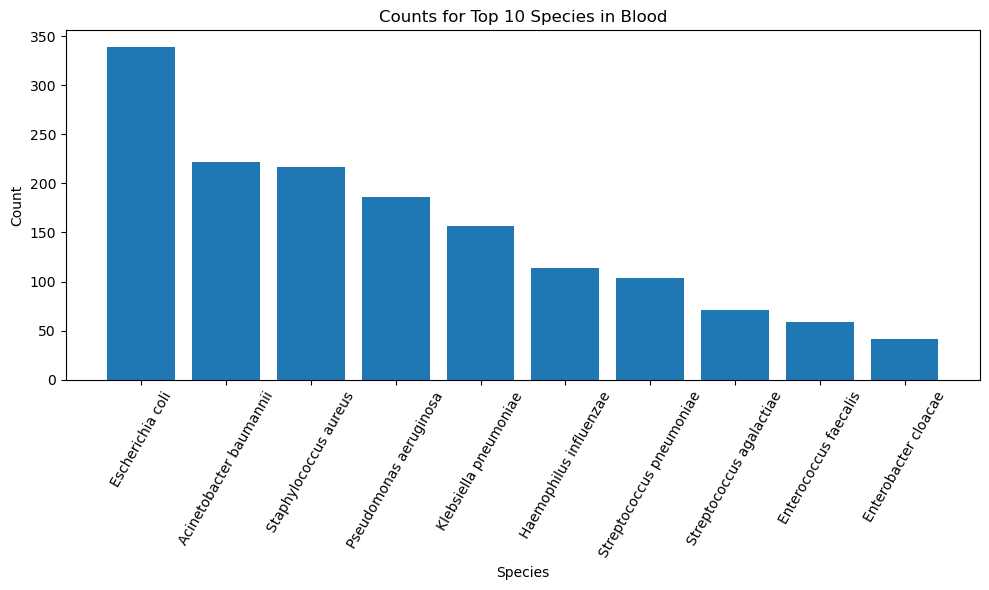

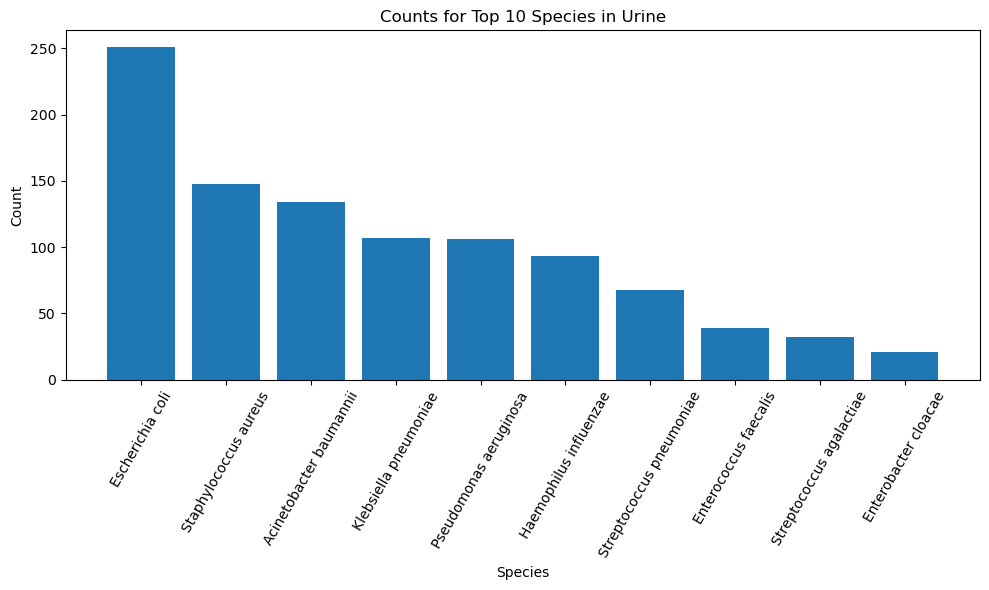

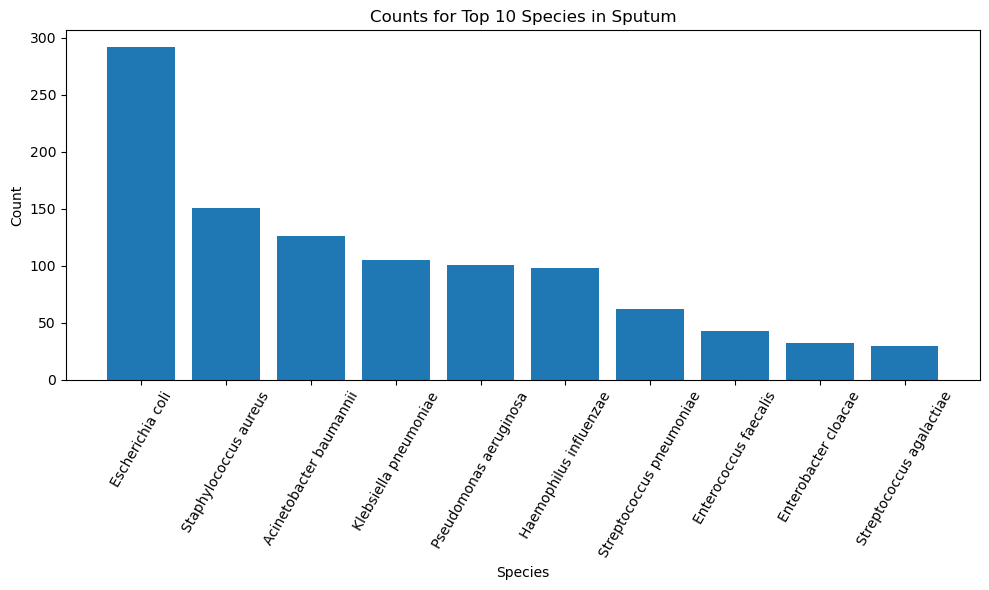

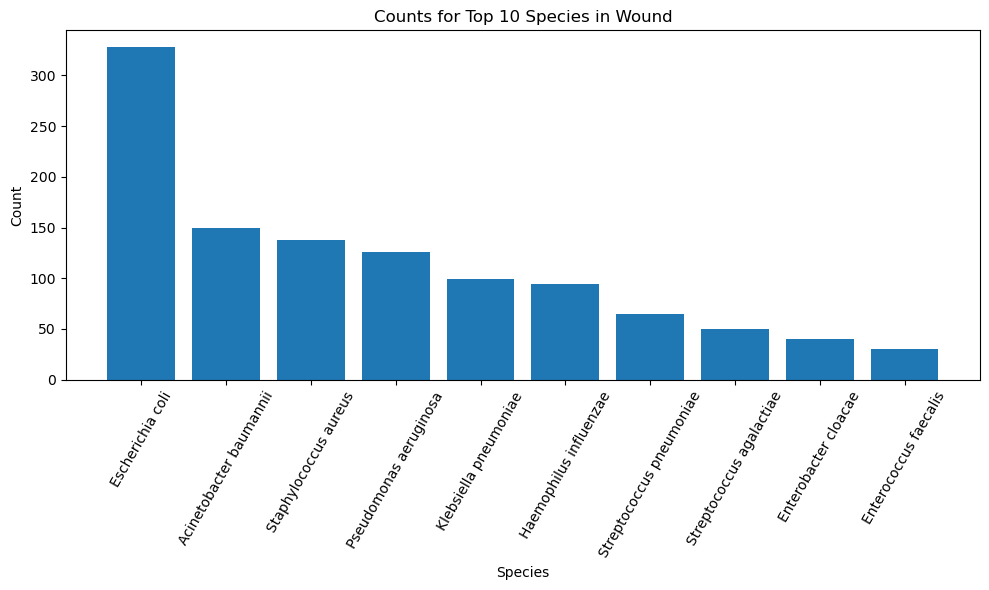

In [49]:
# Plotting the counts of species for each source
data_sample_org_grouped = data.groupby(['species', 'source']).size().reset_index(name='count')

plt.figure(figsize=(15, 10))

top_10_species = data_sample_org_grouped['species'].value_counts().nlargest(10).index

sources = ['Blood', 'Urine', 'Sputum', 'Wound']

# viewing the dataframe. The '\n' is used to add a newline for better readability in the output
print(data_sample_org_grouped.head(),'\n')

for source in sources:
    # Filter the data for the current source and only include top 10 species
    species_data = data_sample_org_grouped[
        (data_sample_org_grouped['source'] == source) &
        (data_sample_org_grouped['species'].isin(top_10_species))
    ].sort_values('count', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(species_data['species'], species_data['count'])

    plt.xlabel('Species')
    plt.ylabel('Count')
    plt.title(f'Counts for Top 10 Species in {source}')

    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()


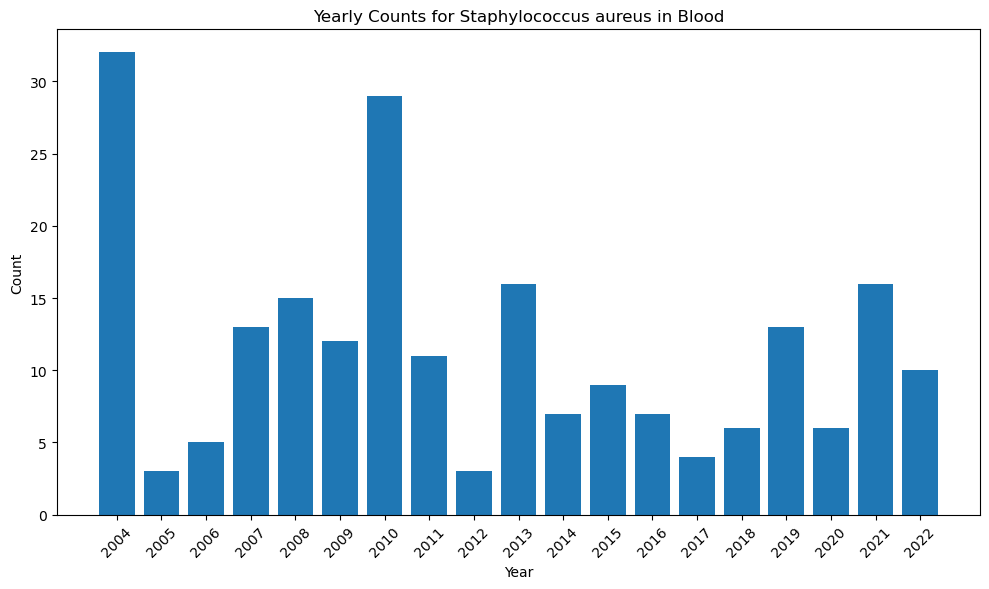

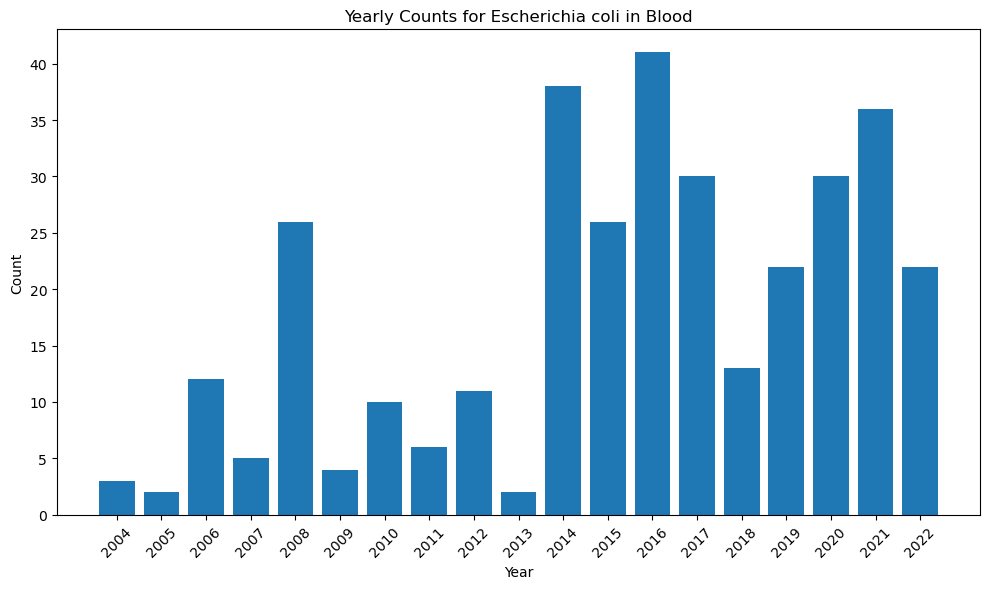

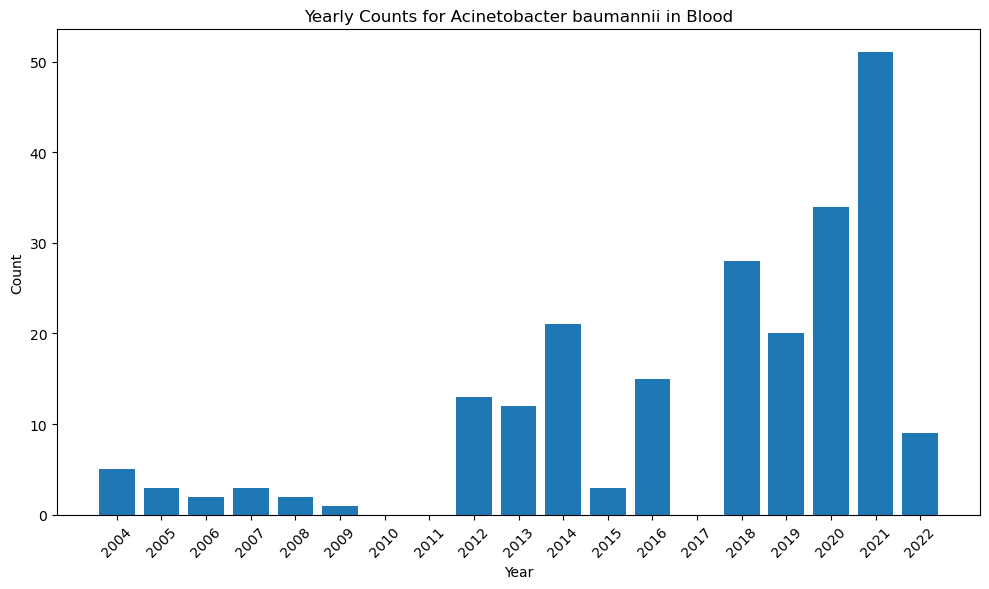

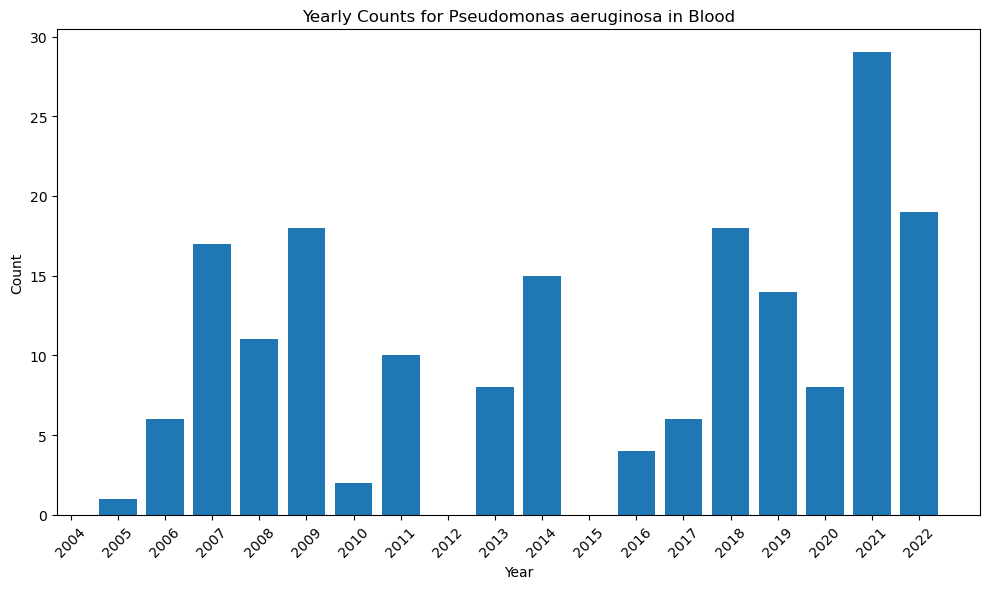

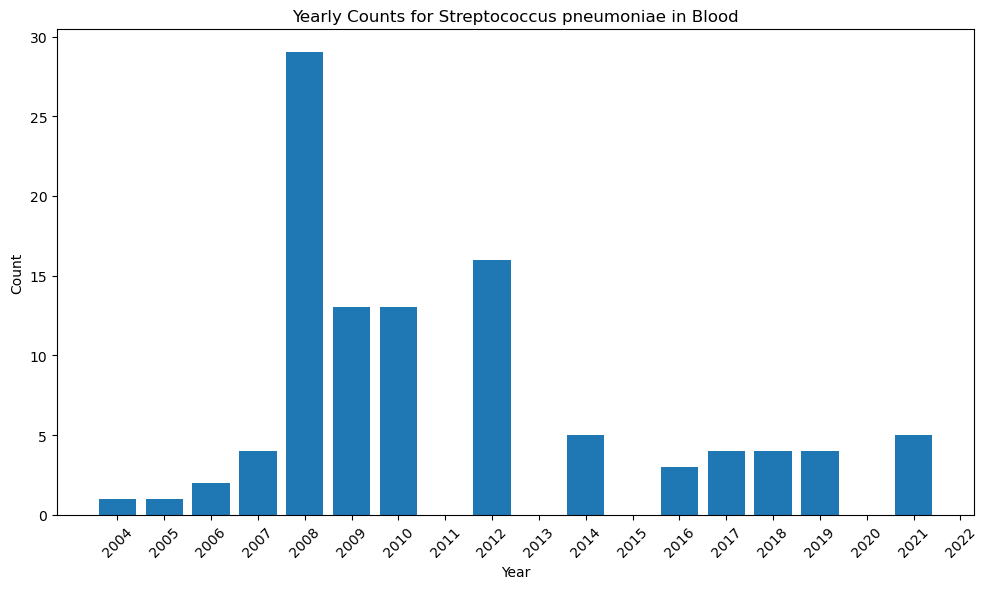

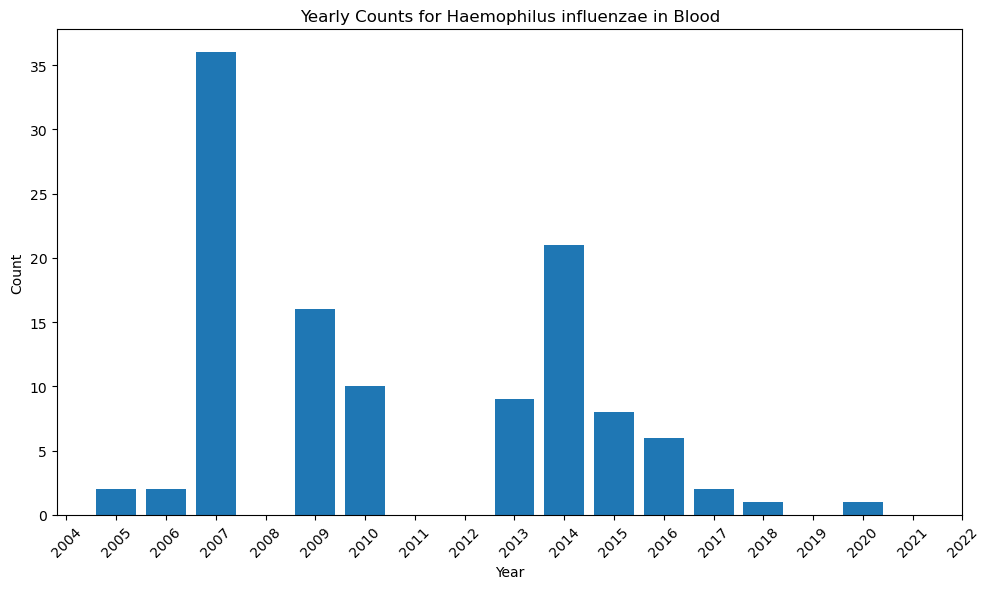

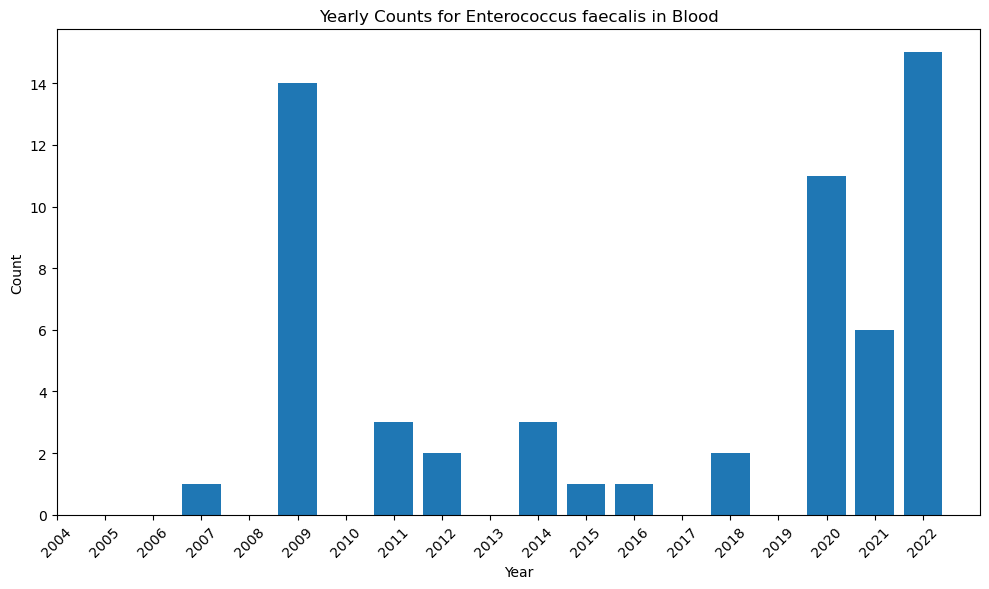

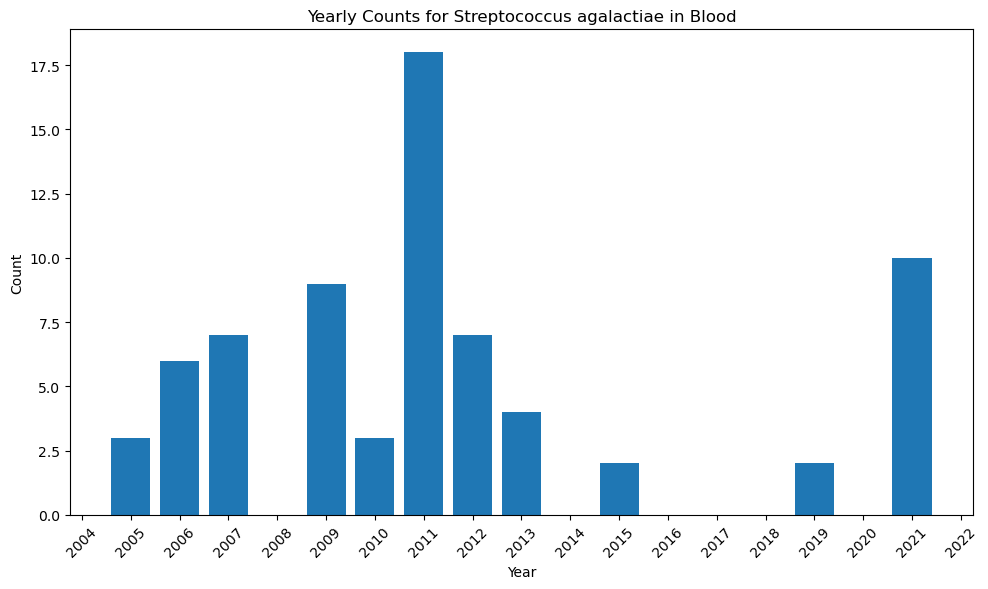

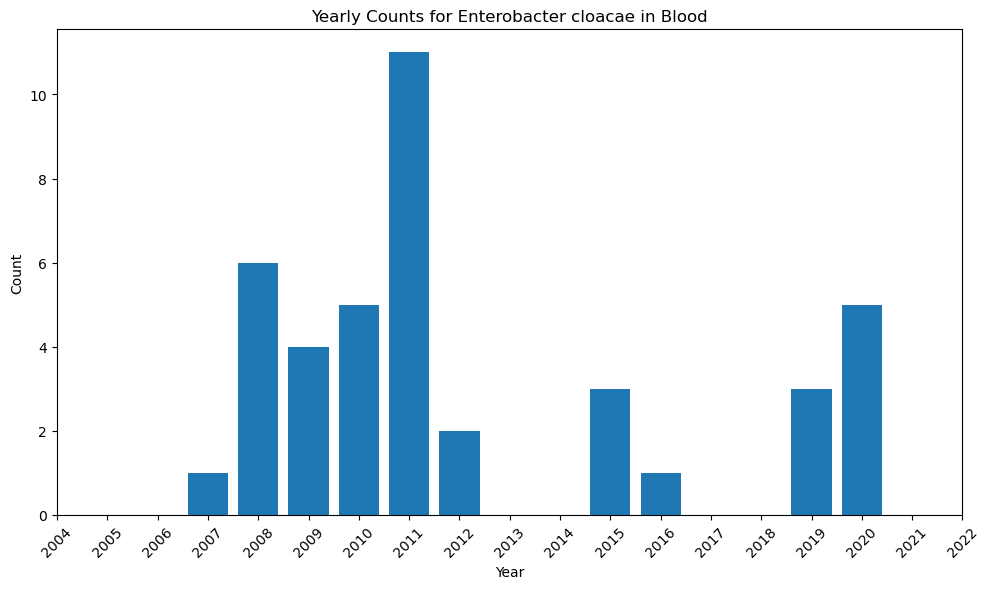

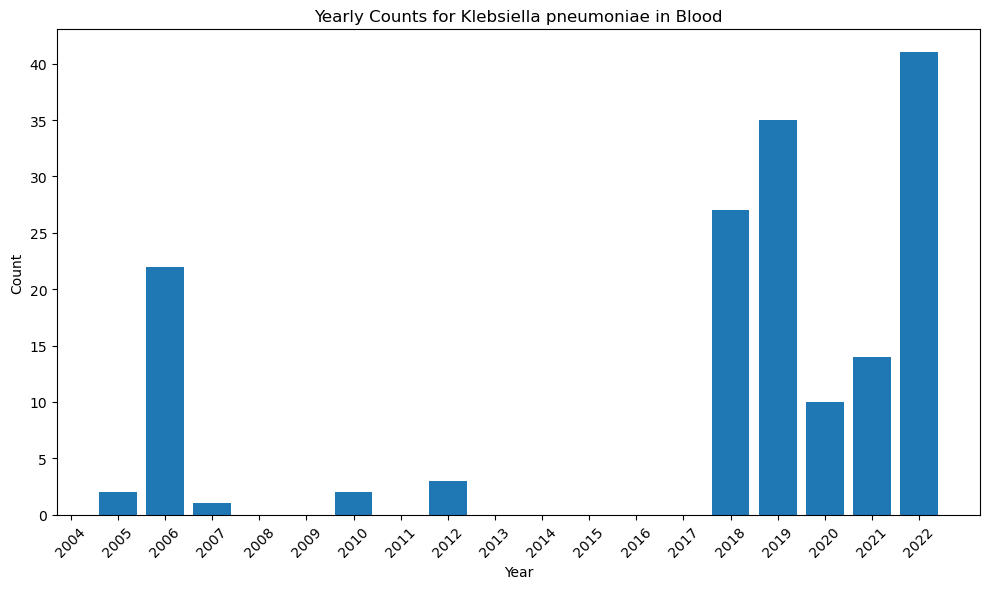

In [50]:
# Filter the data for specimens from Blood source
data_blood = data[data["source"] == "Blood"]

# Group the data by Species and Year, and calculate the counts
data_blood_org_grouped = data_blood.groupby(['species', 'year']).size().reset_index(name='count')

# Get the top 10 species based on their overall counts
top_10_species = data_blood_org_grouped['species'].value_counts().nlargest(10).index

# Get all unique years for consistent x-axis ticks
all_years = sorted(data_blood_org_grouped['year'].unique())

# Loop through each species in the top 10 and create a separate plot for each
for species in top_10_species:
    # Filter the data for the current species
    species_data = data_blood_org_grouped[data_blood_org_grouped['species'] == species].sort_values('count', ascending=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(species_data['year'], species_data['count'])

    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title(f'Yearly Counts for {species} in Blood')
    plt.xticks(ticks=all_years, rotation=45)

    plt.tight_layout()
    plt.show()

In [51]:
def custom_aggregate_number(series, susceptibility="Resistant"):
    unique_counts = series.value_counts(normalize=False)
    total_count = pd.Series.sum(unique_counts)
    return str(unique_counts[susceptibility])+ "/" + str(total_count) if susceptibility in unique_counts else np.nan

def custom_aggregate(series, susceptibility="Resistant"):
    unique_counts = round(series.value_counts(normalize=True) * 100, 2)
    return unique_counts[susceptibility] if susceptibility in unique_counts else np.nan


antibiotics = ["amikacin_i", "amoxycillin_clavulanate_i", "ampicillin_i", "cefepime_i", "ceftazidime_i", "ceftriaxone_i", "imipenem_i", "levofloxacin_i", "meropenem_i"]

organisms = ["Escherichia coli", "Klebsiella pneumoniae"]

for organism in organisms:
    print("Processing.....................................", organism)
    data_blood_org = data_blood[data_blood["species"] == organism]
    for antibiotic in antibiotics:
        result = data_blood_org[antibiotic].agg(custom_aggregate_number)
        result2 = data_blood_org[antibiotic].agg(custom_aggregate)
        print(antibiotic + ", " + str(result) + "(" + str(result2)+ ") " )

Processing..................................... Escherichia coli
amikacin_i, 18/201(8.96) 
amoxycillin_clavulanate_i, 50/165(30.3) 
ampicillin_i, 128/186(68.82) 
cefepime_i, 36/219(16.44) 
ceftazidime_i, 54/201(26.87) 
ceftriaxone_i, 20/127(15.75) 
imipenem_i, 17/131(12.98) 
levofloxacin_i, 88/337(26.11) 
meropenem_i, 24/239(10.04) 
Processing..................................... Klebsiella pneumoniae
amikacin_i, 14/106(13.21) 
amoxycillin_clavulanate_i, 22/71(30.99) 
ampicillin_i, 46/76(60.53) 
cefepime_i, 15/104(14.42) 
ceftazidime_i, 19/89(21.35) 
ceftriaxone_i, 3/30(10.0) 
imipenem_i, 24/96(25.0) 
levofloxacin_i, 42/155(27.1) 
meropenem_i, 18/105(17.14) 


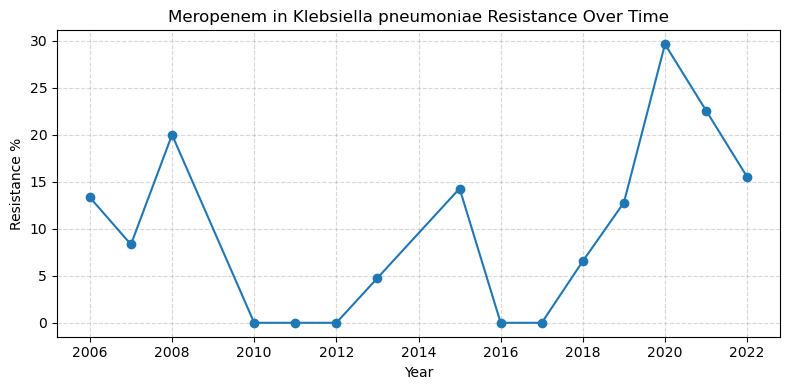

In [52]:
def calc_resistance(data, col):
    """
    Calculate total resistant count and yearly resistance percentage.
    """
    yearly = (
        data.groupby('year')[col]
            .agg(
                resistant=lambda x: (x == 'Resistant').sum(),
                total='count'
            )
            .reset_index()
    )
    yearly['pct'] = yearly['resistant'] / yearly['total'] * 100
    return yearly


def plot_trend(yearly, label):

    years = yearly['year'].to_numpy()
    pct   = yearly['pct'].to_numpy()

    plt.figure(figsize=(8, 4))
    plt.plot(years, pct, marker='o')
    plt.title(f"{label} Resistance Over Time")
    plt.xlabel("Year")
    plt.ylabel("Resistance %")
    plt.grid(True, ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


df_year = calc_resistance(data.query("species=='Klebsiella pneumoniae'"), 'meropenem_i')
plot_trend(df_year, 'Meropenem in Klebsiella pneumoniae')